In [1]:
# Let's make a new basis function that rewards filling a range of airmass
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from rubin_sim.scheduler import basis_functions
from rubin_sim.scheduler import features
from rubin_sim.scheduler.model_observatory import ModelObservatory
import healpy as hp

In [2]:
class AirmassBinsFeature(features.BaseSurveyFeature):
    """Track how many times we have observed at a certain airmass bin. Resets on new night.
    """
    def __init__(self, bin_edges, sigma_am=0.2):
        self.bin_edges = bin_edges
        self.night = -np.nan
        self.sigma_am_sq = sigma_am**2
        self.x = (bin_edges[0:-1] + bin_edges[1:])/2.
        self.feature = np.zeros(np.size(bin_edges)-1, dtype=float)

    def add_observation(self, observation, indx=None):
        # if we are on a new night, reset the feature values
        if observation["night"] != self.night:
            self.feature = np.zeros(np.size(self.bin_edges)-1, dtype=float)
            self.night = observation["night"]
        
        # Check if observation is at an airmass of interest
        if (observation["airmass"].max() < self.bin_edges.max()) & (observation["airmass"].min() > self.bin_edges.min()):
            val = np.exp(-0.5*(self.x - observation["airmass"])**2/self.sigma_am_sq)
            self.feature += val


class AirmassDistBasisFunction(basis_functions.BaseBasisFunction):
    """Reward airmasses that have been observed less than others.
    """
    def __init__(self, nside=32, airmass_bin_edges=None):
        super().__init__(nside=nside)
        if airmass_bin_edges is None:
            # Some reasonable default of what airmass range one wants covered
            # and at what resolution the bins should be
            # XXX--just picking some reasonable looking starting values
            self.airmass_bin_edges = np.arange(0,3.0,0.01)
        else:
            self.airmass_bin_edges = airmass_bin_edges

        self.survey_features["n_airmass"] = AirmassBinsFeature(bin_edges=self.airmass_bin_edges)
        self.result = np.zeros(hp.nside2npix(nside))
        
    def _calc_value(self, conditions, indx=None):
        result = self.result.copy()
        # convert the airmass map to the number of times that bin has been observed
        in_range = np.where((conditions.airmass >= self.airmass_bin_edges.min()) & 
                            (conditions.airmass < self.airmass_bin_edges.max()))
        indx = np.searchsorted(self.airmass_bin_edges, conditions.airmass[in_range]) - 1
        result[in_range] = -self.survey_features["n_airmass"].feature[indx]
        # so we're making it negative here. One could leave it positive, then make the weight on it negative.
        # I dunno which convention makes better sense (or which convention I've been following).
        return result
    

        

In [3]:
nside=32  
mo = ModelObservatory(nside=nside)
conditions = mo.return_conditions()


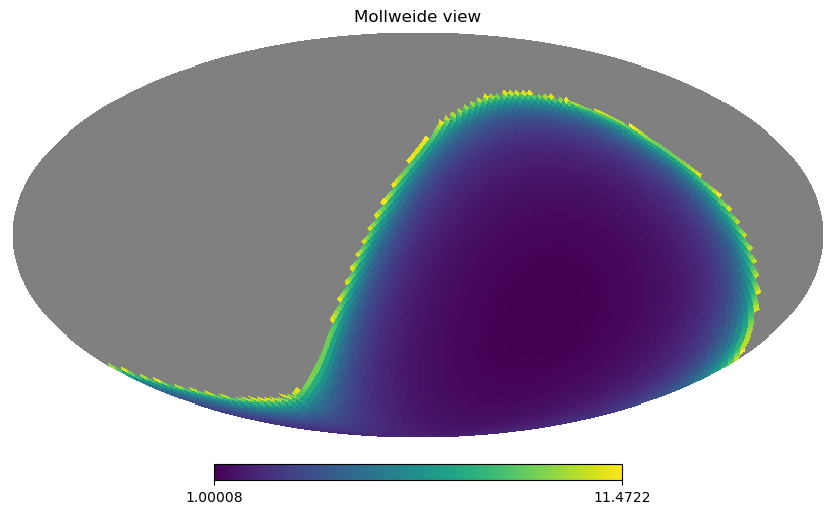

In [4]:
hp.mollview(conditions.airmass)

In [5]:
am_bf = AirmassDistBasisFunction()

In [6]:
am_bf(conditions)

array([ 0.,  0.,  0., ..., -0., -0., -0.])

In [7]:
am_bf.survey_features["n_airmass"].feature

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

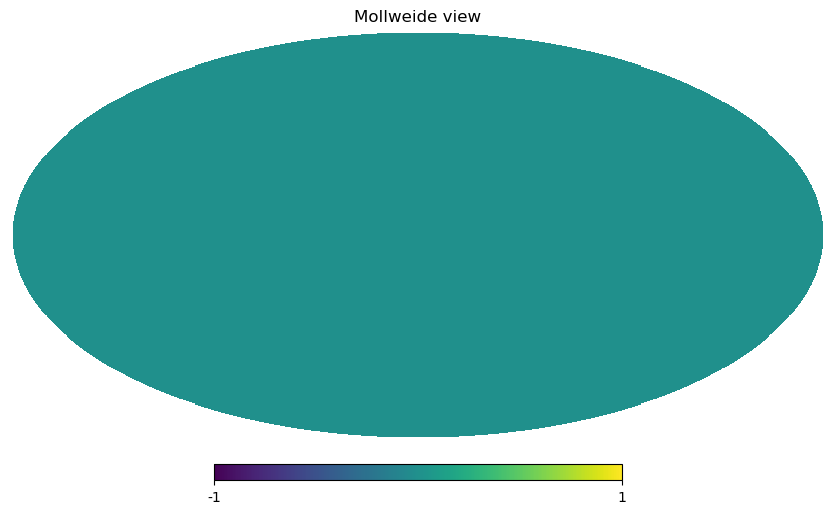

In [8]:
hp.mollview(am_bf(conditions))

In [9]:
observations = np.zeros(10, dtype=[("airmass", float), ("night", int)])
observations["airmass"] = 1.6

In [10]:
# Tell the basis function we've observed 10 times at some airmass
for obs in observations:
    am_bf.add_observation(obs)

In [11]:
am_bf.survey_features["n_airmass"].feature

array([1.54632137e-13, 2.30108052e-13, 3.41568754e-13, 5.05753293e-13,
       7.46987901e-13, 1.10053201e-12, 1.61735760e-12, 2.37095709e-12,
       3.46701401e-12, 5.05710259e-12, 7.35804085e-12, 1.06791550e-11,
       1.54605823e-11, 2.23269330e-11, 3.21622598e-11, 4.62145050e-11,
       6.62406093e-11, 9.47075487e-11, 1.35070074e-10, 1.92153342e-10,
       2.72678572e-10, 3.85983147e-10, 5.45004313e-10, 7.67619148e-10,
       1.07846467e-09, 1.51140311e-09, 2.11285144e-09, 2.94626548e-09,
       4.09816138e-09, 5.68617864e-09, 7.86984549e-09, 1.08649111e-08,
       1.49623707e-08, 2.05536477e-08, 2.81638272e-08, 3.84953875e-08,
       5.24855781e-08, 7.13814784e-08, 9.68378984e-08, 1.31044693e-07,
       1.76891832e-07, 2.38182796e-07, 3.19909592e-07, 4.28606149e-07,
       5.72801039e-07, 7.63595677e-07, 1.01540054e-06, 1.34686969e-06,
       1.78208344e-06, 2.35204027e-06, 3.09653316e-06, 4.06650192e-06,
       5.32697296e-06, 6.96072163e-06, 9.07282018e-06, 1.17962673e-05,
      

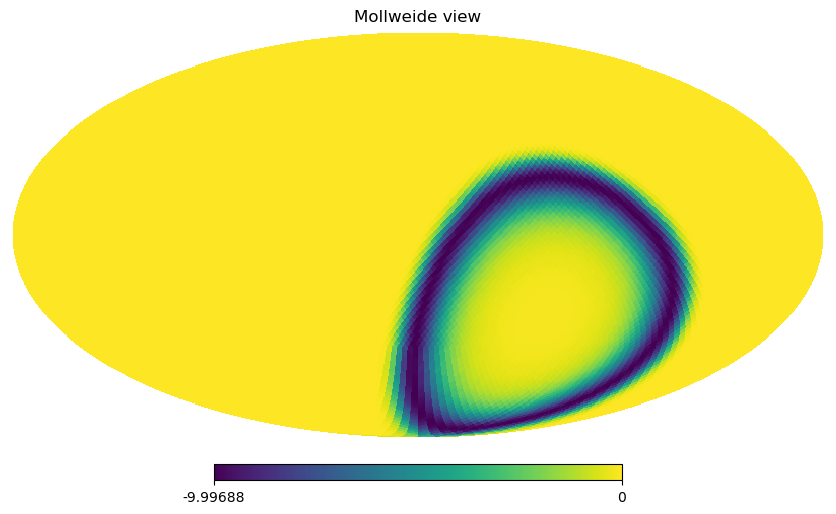

In [12]:
hp.mollview(am_bf(conditions))

In [13]:
# Now say we've observed 10 times at another airmass
observations["airmass"] = 2.8
for obs in observations:
    am_bf.add_observation(obs)

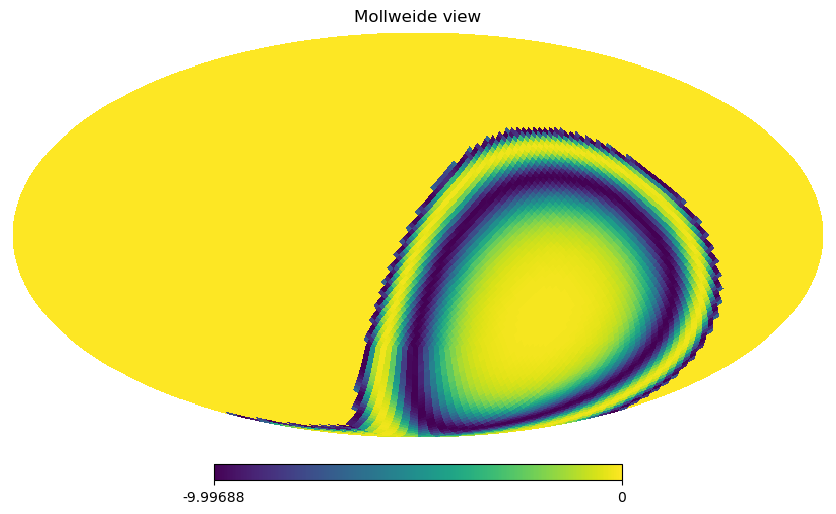

In [14]:
hp.mollview(am_bf(conditions))